![banner](./images/knobs.jpeg)

# Recommendation System for DJ'ing Electronic Music
***
Author: [Paul Lindquist](https://www.linkedin.com/in/paul-lindquist/)

## Overview
***
TBD

## Objective
***
TBD

## Data
***
TBD

## Methods
***
TBD

## Library Imports
***

In [1]:
# Libraries and packages
import pandas as pd
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm
import time
import requests
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
import seaborn as sns
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, GridSearchCV, \
cross_validate
from surprise.prediction_algorithms import knns, KNNWithMeans, \
KNNBasic, KNNBaseline
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Spotify authorization .py
import spotify_authorization

## Manual API Calls to Spotify Web API
***
Registered a Spotify Developer account to get a Client ID and Client Secret. Used this to browse genres within Spotify's "categories."

In [2]:
CLIENT_ID = '4eb9684aba474efa92f55be38917497e'
CLIENT_SECRET = '80f447a4ac9a40ef99dac84fc345e3b9'

AUTH_URL = 'https://accounts.spotify.com/api/token'

auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

auth_response_data = auth_response.json()

access_token = auth_response_data['access_token']

headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

BASE_URL = 'https://api.spotify.com/v1/'

categories = 'browse/categories'

r = requests.get(BASE_URL + categories, headers=headers)

r = r.json()
r

{'categories': {'href': 'https://api.spotify.com/v1/browse/categories?offset=0&limit=20',
  'items': [{'href': 'https://api.spotify.com/v1/browse/categories/toplists',
    'icons': [{'height': 275,
      'url': 'https://t.scdn.co/media/derived/toplists_11160599e6a04ac5d6f2757f5511778f_0_0_275_275.jpg',
      'width': 275}],
    'id': 'toplists',
    'name': 'Top Lists'},
   {'href': 'https://api.spotify.com/v1/browse/categories/hiphop',
    'icons': [{'height': 274,
      'url': 'https://t.scdn.co/media/original/hip-274_0a661854d61e29eace5fe63f73495e68_274x274.jpg',
      'width': 274}],
    'id': 'hiphop',
    'name': 'Hip-Hop'},
   {'href': 'https://api.spotify.com/v1/browse/categories/pop',
    'icons': [{'height': 274,
      'url': 'https://t.scdn.co/media/derived/pop-274x274_447148649685019f5e2a03a39e78ba52_0_0_274_274.jpg',
      'width': 274}],
    'id': 'pop',
    'name': 'Pop'},
   {'href': 'https://api.spotify.com/v1/browse/categories/country',
    'icons': [{'height': None,


In [3]:
BASE_URL = 'https://api.spotify.com/v1/'

dj_music = 'browse/categories/edm_dance'

r = requests.get(BASE_URL + dj_music, headers=headers)

r = r.json()
r

{'href': 'https://api.spotify.com/v1/browse/categories/edm_dance',
 'icons': [{'height': 274,
   'url': 'https://t.scdn.co/media/derived/edm-274x274_0ef612604200a9c14995432994455a6d_0_0_274_274.jpg',
   'width': 274}],
 'id': 'edm_dance',
 'name': 'Dance/Electronic'}

## Data Imports, Creation, Concatenation and Cleaning
***

### Spotify API Calls

In [4]:
# Authorize Spotify API access
sp = spotify_authorization.authorize()

In [5]:
# Get a list of all Spotify genres to narrow down to electronic music-specific
print(sp.recommendation_genre_seeds())

['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient', 'anime', 'black-metal', 'bluegrass', 'blues', 'bossanova', 'brazil', 'breakbeat', 'british', 'cantopop', 'chicago-house', 'children', 'chill', 'classical', 'club', 'comedy', 'country', 'dance', 'dancehall', 'death-metal', 'deep-house', 'detroit-techno', 'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm', 'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk', 'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove', 'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle', 'heavy-metal', 'hip-hop', 'holidays', 'honky-tonk', 'house', 'idm', 'indian', 'indie', 'indie-pop', 'industrial', 'iranian', 'j-dance', 'j-idol', 'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino', 'malay', 'mandopop', 'metal', 'metal-misc', 'metalcore', 'minimal-techno', 'movies', 'mpb', 'new-age', 'new-release', 'opera', 'pagode', 'party', 'philippines-opm', 'piano', 'pop', 'pop-film', 'post-dubstep', 'power-po

In [6]:
# Set genres for electronic music
genres = ['breakbeat', 'chicago-house', 'club', 'dance', 'dancehall',
          'deep-house', 'detroit-techno', 'disco', 'drum-and-bass', 'dub',
          'dubstep', 'edm', 'electro', 'electronic', 'funk', 'garage',
          'hardstyle', 'house', 'idm', 'indie-pop', 'industrial', 'j-dance',
          'minimal-techo', 'new-release', 'party', 'post-dubstep',
          'progressive-house', 'synth-pop', 'techno', 'trance', 'trip-hop',
          'work-out']

Write a function that creates a dictionary of 100 songs for each designated genre listed above

In [7]:
def spotify_dataset_by_genres(genre_list):
    
    # Set number of recommendations per genre (100 max according to Spotify
    # API documentation)
    n_recs = 100
    
    # Create a dictionary with desired info to extract from each genre
    data_dict = {'artist_name': [], 'track_name': [], 'genre': [], 'tempo': [],
                 'danceability': [], 'energy': [], 'valence': [],
                 'loudness': [], 'acousticness': [], 'instrumentalness': [],
                 'liveness': [], 'speechiness': [], 'id': []}
    
    # Get recs for every genre
    for g in genre_list:
        
        # Get n recommendations
        recs = sp.recommendations(genres=[g], limit=n_recs)

        # JSON-like string to dictionary
        recs = eval(recs.json().replace('null', '-999').replace('false', 'False').replace('true', 'True'))['tracks']

        # Iterate through & extract data from each track
        for track in recs:

            # Metadata
            track_meta = sp.track(track['id'])
            data_dict['track_name'].append(track_meta.name)
            data_dict['artist_name'].append(track_meta.album.artists[0].name)

            # ID and genre
            data_dict['genre'].append(g)
            data_dict['id'].append(track['id'])

            # Track features
            track_features = sp.track_audio_features(track['id'])
            data_dict['tempo'].append(track_features.tempo)
            data_dict['danceability'].append(track_features.danceability)
            data_dict['energy'].append(track_features.energy)
            data_dict['valence'].append(track_features.valence)
            data_dict['loudness'].append(track_features.loudness)
            data_dict['acousticness'].append(track_features.acousticness)
            data_dict['instrumentalness'].append(track_features.instrumentalness)
            data_dict['liveness'].append(track_features.liveness)
            data_dict['speechiness'].append(track_features.speechiness)

            # Wait .2 seconds per track so as not to overload API
            time.sleep(0.2)

    # Store data in DataFrame
    df = pd.DataFrame(data_dict)

    # Drop duplicates
    df.drop_duplicates(subset='id', keep='first', inplace=True)

    return df

### Dataset Build-Outs Using Spotify API Call Function

#### *Below is a sample function call used to build datasets. A myriad of ReadTimeout, Bad Gateway, etc. errors related to the API calls and DataFrame creation were returned so, unfortunately, the functions had to be called manually, one at a time.*

In [8]:
# spotify_1 = spotify_dataset_by_genres(genres)

#### *The code blocks below were used to manually create datasets. Due to being computationally expensive, they've been commented out.*

In [9]:
# spotify_2 = spotify_dataset_by_genres(genres)

In [10]:
# spotify_3 = spotify_dataset_by_genres(genres)

In [11]:
# spotify_1_thru_3 = pd.concat([spotify_1, spotify_2, spotify_3],
#                             ignore_index=True)
# spotify_1_thru_3 = spotify_1_thru_3.drop_duplicates(subset='id', keep='first')
# spotify_1_thru_3.to_csv('spotify_rec_pt1.csv', index=False)

In [12]:
# spotify_4 = spotify_dataset_by_genres(genres)

In [13]:
# spotify_5 = spotify_dataset_by_genres(genres)

In [14]:
# spotify_6 = spotify_dataset_by_genres(genres)

In [15]:
# spotify_4_thru_6 = pd.concat([spotify_4, spotify_5, spotify_6],
#                             ignore_index=True)
# spotify_4_thru_6 = spotify_4_thru_6.drop_duplicates(subset='id', keep='first')
# spotify_4_thru_6.to_csv('spotify_rec_pt2.csv', index=False)

In [16]:
# spotify_7 = spotify_dataset_by_genres(genres)

In [17]:
# spotify_8 = spotify_dataset_by_genres(genres)

In [18]:
# spotify_9 = spotify_dataset_by_genres(genres)

In [19]:
# spotify_7_thru_9 = pd.concat([spotify_7, spotify_8, spotify_9],
#                             ignore_index=True)
# spotify_7_thru_9 = spotify_7_thru_9.drop_duplicates(subset='id', keep='first')
# spotify_7_thru_9.to_csv('spotify_rec_pt3.csv', index=False)

In [20]:
# spotify_10 = spotify_dataset_by_genres(genres)

In [21]:
# spotify_11 = spotify_dataset_by_genres(genres)

In [22]:
# spotify_12 = spotify_dataset_by_genres(genres)

In [23]:
# spotify_10_thru_12 = pd.concat([spotify_10, spotify_11, spotify_12],
#                                ignore_index=True)
# spotify_10_thru_12 = spotify_10_thru_12.drop_duplicates(subset='id', keep='first')
# spotify_10_thru_12.to_csv('spotify_rec_pt4.csv', index=False)

In [24]:
# spotify_13 = spotify_dataset_by_genres(genres)

In [25]:
# spotify_14 = spotify_dataset_by_genres(genres)

In [26]:
# spotify_15 = spotify_dataset_by_genres(genres)

In [27]:
# spotify_13_thru_15 = pd.concat([spotify_13, spotify_14, spotify_15],
#                                ignore_index=True)
# spotify_13_thru_15 = spotify_13_thru_15.drop_duplicates(subset='id', keep='first')
# spotify_13_thru_15.to_csv('spotify_rec_pt5.csv', index=False)

### Dataset Imports and Builds

In [28]:
genres_set_1 = pd.read_csv('./data/spotify_rec_pt1.csv')
genres_set_2 = pd.read_csv('./data/spotify_rec_pt2.csv')
genres_set_3 = pd.read_csv('./data/spotify_rec_pt3.csv')
genres_set_4 = pd.read_csv('./data/spotify_rec_pt4.csv')
genres_set_5 = pd.read_csv('./data/spotify_rec_pt5.csv')

sp_more_genres = pd.read_csv('./data/songs_all_genres_trunc.csv')

edm_only_set = pd.read_excel('./data/spotify_edm_only.xlsx')

more_edm = pd.read_csv('./data/more_electronic.csv')

spotify_400k = pd.read_csv('./data/spotify_400k.csv', low_memory=False)

#### Dataset \#1

In [29]:
sp_recommended = pd.concat([genres_set_1, genres_set_2,
                           genres_set_3, genres_set_4,
                           genres_set_5], ignore_index=True)

sp_recommended = sp_recommended.drop_duplicates(subset='id', keep='first')

sp_recommended.rename(columns={'artist_name': 'Artists',
                               'track_name': 'Song_Title',
                               'genre': 'Genre',
                               'tempo': 'Tempo',
                               'danceability': 'Danceability',
                               'energy': 'Energy',
                               'loudness': 'Loudness',
                               'acousticness': 'Acousticness',
                               'instrumentalness': 'Instrumentalness',
                               'liveness': 'Liveness',
                               'speechiness': 'Speechiness',
                               'valence': 'Valence',
                               'id': 'ID'}, inplace=True)

drop_rows = sp_recommended[(sp_recommended['Genre'] == 'breakbeat') & \
                           (sp_recommended['Artists'] == 'Various Artists')].index

sp_recommended.drop(drop_rows, inplace=True)

sp_recommended

,Artists,Song_Title,Genre,Tempo,Danceability,Energy,Valence,Loudness,Acousticness,Instrumentalness,Liveness,Speechiness,ID
0,Eskmo,Cloudlight,breakbeat,139.882,0.423,0.485,0.259,-6.922,0.081700,0.000026,0.1440,0.1450,6TZHtS4pLhJhSEfyV7bmyj
1,Blue Foundation,Eyes on Fire,breakbeat,145.025,0.544,0.383,0.367,-10.143,0.670000,0.002040,0.1250,0.0334,4w3zR0z2oqv8ijhOkTnRvT
2,Stanton Warriors,Get Up - Original Mix,breakbeat,129.984,0.766,0.774,0.896,-7.952,0.022200,0.019600,0.0957,0.0556,4bdMXcKvjt705kx05H7FSk
3,Plump DJs,Tilt,breakbeat,109.029,0.730,0.820,0.372,-8.086,0.001920,0.856000,0.1050,0.0475,5MomjGgGkxqYwyX7cRq8TC
4,Agent K,Good To Go,breakbeat,135.993,0.619,0.935,0.397,-8.994,0.000546,0.760000,0.4000,0.0453,42iBqLosPxTVZDTWkdQRpt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27237,Florence + The Machine,Shake It Out,work-out,107.486,0.527,0.804,0.221,-4.168,0.010400,0.000000,0.1050,0.0358,4lY95OMGb9WxP6IYut64ir
27238,Avril Lavigne,What the Hell,work-out,149.964,0.577,0.934,0.855,-3.672,0.004050,0.006400,0.1230,0.0554,10zycm3kRmxg5etQ8Qhpq4
27247,Christina Aguilera,Dirrty (feat. Redman),work-out,99.931,0.640,0.889,0.436,-3.073,0.107000,0.000000,0.3390,0.3220,59ZTxQo8rBycIXPLUIKvE2
27248,Guns N' Roses,Paradise City,work-out,100.271,0.273,0.952,0.472,-8.762,0.016900,0.011100,0.1420,0.0843,3YBZIN3rekqsKxbJc9FZko


#### Dataset \#2

In [30]:
sp_more_genres = sp_more_genres.drop_duplicates(subset='Id', keep='first')

sp_more_genres

,Name,Id,Artists,Artists_Id,Release,Duration,Genre,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valeance,Tempo
0,Hero,29p6UW08MXzwj9thWBW3uF,"['Afrojack', 'David Guetta']","['4D75GcNG95ebPtNvoNVXhz', '1Cs0zKBU1kc0i8ypK3...",4/30/21,171840,edm,0.713,0.772,2,-5.032,0.0313,0.157000,0.0000,0.1530,0.5230,125.001
1,Chasing Stars (feat. James Bay),6y6xhAgZjvxy5kR5rigpY3,"['Alesso', 'Marshmello', 'James Bay']","['4AVFqumd2ogHFlRbKIjp1t', '64KEffDW9EtZ1y2vBY...",8/20/21,170457,edm,0.594,0.640,10,-6.865,0.0330,0.016900,0.0000,0.1350,0.4920,92.871
2,Gotta Be You,2Q8fFORnsDE6I3RNvSLXSf,"['NERVO', 'Carla Monroe']","['4j5KBTO4tk7up54ZirNGvK', '4S9LNSZusH3XflT3g3...",1/8/21,149032,edm,0.642,0.869,6,-5.271,0.0452,0.252000,0.0288,0.0708,0.3760,123.910
3,Okay,71H8k9qe7DersxR6KyhUnI,"['Nicky Romero', 'MARF', 'Wulf']","['5ChF3i92IPZHduM7jN3dpg', '6y1eDna5tYFgcvKyGh...",7/23/21,151312,edm,0.513,0.836,2,-3.781,0.0579,0.046300,0.0000,0.1280,0.3040,124.964
4,Get Low,3oZoXyU0SkDldgS7AcN4y4,"['Dillon Francis', 'DJ Snake']","['5R3Hr2cnCCjt220Jmt2xLf', '540vIaP2JwjQb9dm3a...",10/22/14,212773,edm,0.674,0.932,11,-4.424,0.0859,0.028200,0.7100,0.6840,0.7280,101.033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160,Aiguilhe,2K0uZFmADV2hpSvJITvGoL,['Joris Delacroix'],['3HRRzIZNQFus3xlUx2xKy1'],11/19/20,289268,deep house,0.687,0.892,4,-7.473,0.0613,0.205000,0.8140,0.0636,0.1970,123.026
4161,Disco,707SqZpNC3qGHAP0FSQjqL,['Krueger & Leu'],['1K5AMz99qCSXYrMQJIUGw2'],5/21/13,384823,deep house,0.872,0.608,7,-10.852,0.0458,0.000779,0.6200,0.0861,0.4910,121.015
4163,Can I,3qavQewlgidBuYHrJe3Qqb,['Britta Arnold'],['7JpBTUqubY86KynSJr28RN'],3/19/21,511990,deep house,0.809,0.667,7,-7.797,0.0565,0.000623,0.8330,0.0920,0.0325,120.019
4164,By Defection,2auhKxSJCfnsaOVxFoF3uA,['Dixie Yure'],['63Hs70Er0FXT7oVFaiP3Xb'],4/27/10,506468,deep house,0.927,0.513,5,-8.091,0.0646,0.011700,0.7900,0.1680,0.2420,124.019


#### Dataset \#3

In [31]:
edm_only_set = edm_only_set.drop_duplicates(subset='id', keep='first')

edm_only_set

,Genre,Title,Album_cover_link,Artist,duration_ms,explicit,id,popularity,release_date,release_date_precision,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,edm,Hero,https://i.scdn.co/image/ab67616d0000b27368c134...,Afrojack,171840,False,29p6UW08MXzwj9thWBW3uF,73,2021-04-30,day,...,2,-5.032,1,0.0313,0.15700,0.000000,0.1530,0.523,125.001,4
1,edm,Real Love (feat. Aleyna Tilki),https://i.scdn.co/image/ab67616d0000b2738fe23c...,Dillon Francis,135265,False,7BxIvkfVSgoUUlDcBVff61,48,2021-10-05,day,...,10,-4.313,0,0.0685,0.04960,0.000085,0.0522,0.555,124.012,4
2,edm,Gotta Be You,https://i.scdn.co/image/ab67616d0000b27329204e...,NERVO,149032,False,2Q8fFORnsDE6I3RNvSLXSf,67,2021-01-08,day,...,6,-5.271,0,0.0452,0.25200,0.028800,0.0708,0.376,123.910,4
3,edm,Okay,https://i.scdn.co/image/ab67616d0000b2737dd8c5...,Nicky Romero,151312,False,1muUz481pBOMzJ9De3NS6e,33,2021-09-10,day,...,2,-3.781,1,0.0579,0.04630,0.000000,0.1280,0.304,124.964,4
4,edm,Worst Case,https://i.scdn.co/image/ab67616d0000b273380a16...,3LAU,178048,False,3zbbRebB1rzlXJgq7Ufn8V,62,2021-10-08,day,...,6,-5.775,0,0.0339,0.00463,0.034700,0.2050,0.177,122.975,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,edm,Break Me,https://i.scdn.co/image/ab67616d0000b273c3bbe6...,Trivecta,222631,False,3cjkfbF4rgqymxtRn7Iv15,43,2017-07-03,day,...,11,-4.150,0,0.1680,0.04980,0.000003,0.3460,0.463,75.995,4
952,edm,Shiawase - VIP,https://i.scdn.co/image/ab67616d0000b273d1dcf9...,Dion Timmer,181750,False,4mTLnLuHoGhA2xd595OMg1,47,2020-09-09,day,...,8,-0.563,1,0.1540,0.00612,0.000176,0.6650,0.500,150.096,4
953,edm,Left Behinds - Radio Edit,https://i.scdn.co/image/ab67616d0000b2737fff2e...,Paris Blohm,180014,False,2Lmk4VmhPzw6fw3kvKmmUe,23,2014-08-04,day,...,8,-4.051,0,0.1520,0.00185,0.033100,0.1430,0.155,128.027,4
954,edm,R.E.A.L,https://i.scdn.co/image/ab67616d0000b273389ba0...,Dombresky,183095,False,1mK6vQxrBu7tStp3b8G2Z9,53,2021-10-15,day,...,0,-3.240,1,0.0741,0.00106,0.834000,0.0348,0.768,126.003,4


#### Dataset \#4

In [32]:
more_edm = more_edm.drop_duplicates(subset='Uri', keep='first')

more_edm

,Uri,Title,Artist,Genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,https://open.spotify.com/track/1yfyIdEw5U2bD5I...,tough love,Avicii - Agnes - Vargas & Lagola,big room,0.402,0.754,-4.837,0.0432,0.14300,0.000000,0.3580,0.621,108.170
1,https://open.spotify.com/track/4hiUYb2nb6NlfTP...,on my way,Tiësto - Bright Sparks,big room,0.629,0.764,-4.023,0.0360,0.00981,0.000000,0.2210,0.577,123.972
2,https://open.spotify.com/track/6J7ZSdEEYo3ns4g...,seek bromance - avicii vocal edit,Tim Berg - Avicii,big room,0.515,0.837,-2.552,0.0401,0.08680,0.000000,0.0403,0.520,126.026
3,https://open.spotify.com/track/6WbADFqMvR8N5u0...,without you,Avicii - Sandro Cavazza,big room,0.652,0.855,-4.832,0.0441,0.00179,0.000000,0.0404,0.279,134.009
4,https://open.spotify.com/track/3zKST4nk4QJE77o...,hey brother,Avicii,big room,0.545,0.780,-4.867,0.0436,0.03090,0.000046,0.0828,0.458,125.014
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,https://open.spotify.com/track/0XPsOSYzDJZJAre...,speechless,Naomi Scott,vapor pop,0.474,0.489,-7.625,0.0342,0.46700,0.000000,0.1190,0.230,124.844
4418,https://open.spotify.com/track/1kMUGCt7XLDc5Q6...,bellacoso,Residente - Bad Bunny,venezuelan hip hop,0.774,0.851,-2.795,0.2550,0.06510,0.000000,0.0568,0.695,180.086
4419,https://open.spotify.com/track/6gm12xlADJwiBbH...,rené,Residente,venezuelan hip hop,0.486,0.388,-9.326,0.1260,0.43500,0.000000,0.1960,0.467,90.471
4420,https://open.spotify.com/track/2alc8VZAzDgdAsL...,skechers,DripReport,viral rap,0.903,0.327,-9.727,0.0877,0.26000,0.011000,0.1080,0.274,100.008


#### Dataset \#5

In [33]:
spotify_400k = spotify_400k.drop_duplicates(subset='Id', keep='first')

spotify_400k

,Name,Id,Artists,Genre,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,Don't Go Yet,1058fW9H3fZA6QjYCdOBad,['Camila Cabello'],pop,0.666,0.7960,-6.967,0.1030,0.0492,0.000000,0.0442,0.6100,110.108
1,What A Time (feat. Niall Horan),5WtfUKzXircvW8l5aaVZWT,"['Julia Michaels', 'Niall Horan']",pop,0.516,0.4670,-6.184,0.0302,0.6620,0.000000,0.0853,0.3860,132.861
2,Scars To Your Beautiful,42ydLwx4i5V49RXHOozJZq,['Alessia Cara'],pop,0.319,0.7390,-5.740,0.2720,0.0285,0.000000,0.1110,0.4490,194.169
3,Reckless,5ajjAnNRh8bxFvaVHzpPjh,['Madison Beer'],pop,0.386,0.4260,-6.642,0.0363,0.8070,0.000000,0.1400,0.2610,180.104
4,Dusk Till Dawn (feat. Sia) - Radio Edit,3e7sxremeOE3wTySiOhGiP,"['ZAYN', 'Sia']",pop,0.259,0.4370,-6.589,0.0386,0.1020,0.000001,0.1060,0.0951,180.042
...,...,...,...,...,...,...,...,...,...,...,...,...,...
444177,"String Trio in C Minor, Op. 9, No. 3: IV. Fina...",3LKmf7uAN2xhK87elaGvKN,"['Ludwig van Beethoven', 'Janaki String Trio']",ugandan traditional,0.464,0.0671,-20.093,0.0424,0.8170,0.460000,0.1190,0.4090,105.152
444178,"Divertimento in E-Flat Major, K. 563 ('Di sei ...",5Vqmp5wdAiQMn1DaQK161R,"['Wolfgang Amadeus Mozart', 'Jacques Thibaud S...",ugandan traditional,0.365,0.1250,-16.972,0.0402,0.9470,0.637000,0.1130,0.3490,118.562
444179,"Baryton Trio No. 109 in C Major, Hob.XI:109: I...",4FcVIxHUKVY9UQ4B7ZDJll,"['Franz Joseph Haydn', 'Vienna Belvedere Trio']",ugandan traditional,0.371,0.0200,-20.062,0.0479,0.9830,0.026400,0.0904,0.1200,74.202
444180,"Concert Trio No. 1 in B-Flat Major, Op. 1, No....",7kCpFbgNcm8oyvTBfVTm8B,"['Alessandro Rolla', 'Budapest String Trio']",ugandan traditional,0.256,0.0740,-21.666,0.0502,0.9650,0.397000,0.1030,0.1210,103.362


### Data Cleaning

In [34]:
drop_cols = ['Album_cover_link', 'duration_ms', 'explicit', 'popularity',
            'release_date', 'release_date_precision', 'total_tracks',
            'key', 'mode', 'time_signature']

In [35]:
drop_cols_2 = ['Artists_Id', 'Release', 'Duration', 'Key']

In [36]:
cols_order = ['Song_Title', 'Artists', 'Genre', 'Tempo', 'Danceability',
              'Energy', 'Valence', 'Loudness', 'Acousticness',
              'Instrumentalness', 'Liveness', 'Speechiness', 'ID']

In [37]:
genres_to_keep = ['tech house', 'deep house', 'acid techno', 'progressive trance house',
                 'deep euro house', 'deep vocal house', 'deep big room', 'acid trance',
                 'ambient house', 'edm', 'dutch trap', 'modular techno', 'synthpop',
                 'deep pop edm', 'pop house', 'ambient techno', 'destroy techno',
                 'french tech house', 'bass music', 'uplifting trance', 'pop edm',
                 'deep hardtechno', 'ambient techno', 'disco', 'disco house', 'dutch trance',
                 'tech trance', 're:techno', 'dark disco', 'lo-fi house',
                 'deep tropical house', 'latin house', 'electro house,', 'tropical house',
                 'house', 'trance', 'indietronica', 'brostep', 'metropopolis', 'progressive house',
                 'deep progressive house', 'dutch house', 'progressive electro house', 'electronica',
                 'big room', 'pop dance', 'electropop', 'electronic trap', '90s eurodance',
                 'brazilian edm', '90s dance', 'filter house', 'complextro', 'commercial house',
                 'dance', 'commercial', 'dance pop', 'aussietronica', 'chicago house', 'big beat']

#### Dataset \#1

In [38]:
sp_recommended = sp_recommended[cols_order]
sp_recommended

,Song_Title,Artists,Genre,Tempo,Danceability,Energy,Valence,Loudness,Acousticness,Instrumentalness,Liveness,Speechiness,ID
0,Cloudlight,Eskmo,breakbeat,139.882,0.423,0.485,0.259,-6.922,0.081700,0.000026,0.1440,0.1450,6TZHtS4pLhJhSEfyV7bmyj
1,Eyes on Fire,Blue Foundation,breakbeat,145.025,0.544,0.383,0.367,-10.143,0.670000,0.002040,0.1250,0.0334,4w3zR0z2oqv8ijhOkTnRvT
2,Get Up - Original Mix,Stanton Warriors,breakbeat,129.984,0.766,0.774,0.896,-7.952,0.022200,0.019600,0.0957,0.0556,4bdMXcKvjt705kx05H7FSk
3,Tilt,Plump DJs,breakbeat,109.029,0.730,0.820,0.372,-8.086,0.001920,0.856000,0.1050,0.0475,5MomjGgGkxqYwyX7cRq8TC
4,Good To Go,Agent K,breakbeat,135.993,0.619,0.935,0.397,-8.994,0.000546,0.760000,0.4000,0.0453,42iBqLosPxTVZDTWkdQRpt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27237,Shake It Out,Florence + The Machine,work-out,107.486,0.527,0.804,0.221,-4.168,0.010400,0.000000,0.1050,0.0358,4lY95OMGb9WxP6IYut64ir
27238,What the Hell,Avril Lavigne,work-out,149.964,0.577,0.934,0.855,-3.672,0.004050,0.006400,0.1230,0.0554,10zycm3kRmxg5etQ8Qhpq4
27247,Dirrty (feat. Redman),Christina Aguilera,work-out,99.931,0.640,0.889,0.436,-3.073,0.107000,0.000000,0.3390,0.3220,59ZTxQo8rBycIXPLUIKvE2
27248,Paradise City,Guns N' Roses,work-out,100.271,0.273,0.952,0.472,-8.762,0.016900,0.011100,0.1420,0.0843,3YBZIN3rekqsKxbJc9FZko


#### Dataset \#2

In [39]:
edm_only_set.drop(columns=drop_cols, inplace=True)

edm_only_set.rename(columns={'Artist': 'Artists',
                            'Title': 'Song_Title',
                            'tempo': 'Tempo',
                            'danceability': 'Danceability',
                            'energy': 'Energy',
                            'valence': 'Valence',
                            'loudness': 'Loudness',
                            'acousticness': 'Acousticness',
                            'instrumentalness': 'Instrumentalness',
                            'liveness': 'Liveness',
                            'speechiness': 'Speechiness',
                            'id': 'ID'}, inplace=True)

edm_only = edm_only_set[cols_order]

edm_only

,Song_Title,Artists,Genre,Tempo,Danceability,Energy,Valence,Loudness,Acousticness,Instrumentalness,Liveness,Speechiness,ID
0,Hero,Afrojack,edm,125.001,0.713,0.772,0.523,-5.032,0.15700,0.000000,0.1530,0.0313,29p6UW08MXzwj9thWBW3uF
1,Real Love (feat. Aleyna Tilki),Dillon Francis,edm,124.012,0.738,0.793,0.555,-4.313,0.04960,0.000085,0.0522,0.0685,7BxIvkfVSgoUUlDcBVff61
2,Gotta Be You,NERVO,edm,123.910,0.642,0.869,0.376,-5.271,0.25200,0.028800,0.0708,0.0452,2Q8fFORnsDE6I3RNvSLXSf
3,Okay,Nicky Romero,edm,124.964,0.513,0.836,0.304,-3.781,0.04630,0.000000,0.1280,0.0579,1muUz481pBOMzJ9De3NS6e
4,Worst Case,3LAU,edm,122.975,0.629,0.809,0.177,-5.775,0.00463,0.034700,0.2050,0.0339,3zbbRebB1rzlXJgq7Ufn8V
...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,Break Me,Trivecta,edm,75.995,0.407,0.885,0.463,-4.150,0.04980,0.000003,0.3460,0.1680,3cjkfbF4rgqymxtRn7Iv15
952,Shiawase - VIP,Dion Timmer,edm,150.096,0.557,0.980,0.500,-0.563,0.00612,0.000176,0.6650,0.1540,4mTLnLuHoGhA2xd595OMg1
953,Left Behinds - Radio Edit,Paris Blohm,edm,128.027,0.488,0.957,0.155,-4.051,0.00185,0.033100,0.1430,0.1520,2Lmk4VmhPzw6fw3kvKmmUe
954,R.E.A.L,Dombresky,edm,126.003,0.800,0.984,0.768,-3.240,0.00106,0.834000,0.0348,0.0741,1mK6vQxrBu7tStp3b8G2Z9


#### Dataset \#3

In [40]:
more_edm['Uri'] = more_edm['Uri'].str.replace('https://open.spotify.com/track/','',
                                             regex=False)

more_edm = more_edm.loc[more_edm['Genre'].isin(genres_to_keep)].copy()

more_edm.rename(columns={'Artist': 'Artists',
                        'Title': 'Song_Title',
                        'tempo': 'Tempo',
                        'danceability': 'Danceability',
                        'energy': 'Energy',
                        'valence': 'Valence',
                        'Uri': 'ID',
                        'loudness': 'Loudness',
                        'speechiness': 'Speechiness',
                        'acousticness': 'Acousticness',
                        'instrumentalness': 'Instrumentalness',
                        'liveness': 'Liveness'}, inplace=True)

more_edm = more_edm[cols_order]

more_edm

,Song_Title,Artists,Genre,Tempo,Danceability,Energy,Valence,Loudness,Acousticness,Instrumentalness,Liveness,Speechiness,ID
0,tough love,Avicii - Agnes - Vargas & Lagola,big room,108.170,0.402,0.754,0.621,-4.837,0.14300,0.000000,0.3580,0.0432,1yfyIdEw5U2bD5I6gxQCxW
1,on my way,Tiësto - Bright Sparks,big room,123.972,0.629,0.764,0.577,-4.023,0.00981,0.000000,0.2210,0.0360,4hiUYb2nb6NlfTP9CD38Pe
2,seek bromance - avicii vocal edit,Tim Berg - Avicii,big room,126.026,0.515,0.837,0.520,-2.552,0.08680,0.000000,0.0403,0.0401,6J7ZSdEEYo3ns4gnHdwRL0
3,without you,Avicii - Sandro Cavazza,big room,134.009,0.652,0.855,0.279,-4.832,0.00179,0.000000,0.0404,0.0441,6WbADFqMvR8N5u0BvtsWQE
4,hey brother,Avicii,big room,125.014,0.545,0.780,0.458,-4.867,0.03090,0.000046,0.0828,0.0436,3zKST4nk4QJE77oLjUZ0Ng
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,creep on me,GASHI - French Montana - DJ Snake,pop dance,134.598,0.449,0.597,0.505,-4.401,0.34700,0.000010,0.1970,0.1400,1MUL6DO2gVimj2YrVedubd
4234,lovefool,twocolors,pop edm,123.062,0.677,0.766,0.198,-6.896,0.02190,0.000007,0.1290,0.0568,51Of5p3lKZeOg6itfs4og4
4235,i miss you,Grey - Bahari,pop edm,102.010,0.650,0.764,0.704,-5.219,0.36800,0.000000,0.1200,0.0939,1sl5tSzfK1JrcQIcA8rYDy
4398,ily,Surf Mesa - Emilee,tropical house,112.050,0.674,0.774,0.330,-7.567,0.06860,0.001880,0.3930,0.0892,62aP9fBQKYKxi7PDXwcUAS


#### Dataset \#4

In [41]:
sp_more_genres.drop(columns=drop_cols_2, inplace=True)

sp_more_genres.rename(columns={'Name': 'Song_Title', 'Id': 'ID',
                               'Valeance': 'Valence'}, inplace=True)

sp_more_genres = sp_more_genres[cols_order]

more_genres = sp_more_genres.loc[sp_more_genres['Genre'].isin(genres_to_keep)].copy()

more_genres['Artists'] = more_genres['Artists'].str.replace(r'[^0-9a-zA-Z:,\s]+', '', regex=True)

more_genres

,Song_Title,Artists,Genre,Tempo,Danceability,Energy,Valence,Loudness,Acousticness,Instrumentalness,Liveness,Speechiness,ID
0,Hero,"Afrojack, David Guetta",edm,125.001,0.713,0.772,0.5230,-5.032,0.157000,0.0000,0.1530,0.0313,29p6UW08MXzwj9thWBW3uF
1,Chasing Stars (feat. James Bay),"Alesso, Marshmello, James Bay",edm,92.871,0.594,0.640,0.4920,-6.865,0.016900,0.0000,0.1350,0.0330,6y6xhAgZjvxy5kR5rigpY3
2,Gotta Be You,"NERVO, Carla Monroe",edm,123.910,0.642,0.869,0.3760,-5.271,0.252000,0.0288,0.0708,0.0452,2Q8fFORnsDE6I3RNvSLXSf
3,Okay,"Nicky Romero, MARF, Wulf",edm,124.964,0.513,0.836,0.3040,-3.781,0.046300,0.0000,0.1280,0.0579,71H8k9qe7DersxR6KyhUnI
4,Get Low,"Dillon Francis, DJ Snake",edm,101.033,0.674,0.932,0.7280,-4.424,0.028200,0.7100,0.6840,0.0859,3oZoXyU0SkDldgS7AcN4y4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160,Aiguilhe,Joris Delacroix,deep house,123.026,0.687,0.892,0.1970,-7.473,0.205000,0.8140,0.0636,0.0613,2K0uZFmADV2hpSvJITvGoL
4161,Disco,Krueger Leu,deep house,121.015,0.872,0.608,0.4910,-10.852,0.000779,0.6200,0.0861,0.0458,707SqZpNC3qGHAP0FSQjqL
4163,Can I,Britta Arnold,deep house,120.019,0.809,0.667,0.0325,-7.797,0.000623,0.8330,0.0920,0.0565,3qavQewlgidBuYHrJe3Qqb
4164,By Defection,Dixie Yure,deep house,124.019,0.927,0.513,0.2420,-8.091,0.011700,0.7900,0.1680,0.0646,2auhKxSJCfnsaOVxFoF3uA


#### Dataset \#5

In [42]:
spotify_400k.rename(columns={'Name': 'Song_Title', 'Id': 'ID'}, inplace=True)

spotify_400k = spotify_400k[cols_order]

spotify_400k = spotify_400k.loc[spotify_400k['Genre'].isin(genres_to_keep)].copy()

spotify_400k['Artists'] = spotify_400k['Artists'].str.replace(r'[^0-9a-zA-Z:,\s]+', '', regex=True)

spotify_400k

,Song_Title,Artists,Genre,Tempo,Danceability,Energy,Valence,Loudness,Acousticness,Instrumentalness,Liveness,Speechiness,ID
100,On The Floor,"Jennifer Lopez, Pitbull",dance pop,130.000,0.730,0.7770,0.5750,-5.194,0.1050,0.000478,0.0691,0.0496,3C0nOe05EIt1390bVABLyN
101,The Sweet Escape,"Gwen Stefani, Akon",dance pop,119.961,0.756,0.7700,0.7300,-3.502,0.1910,0.000000,0.1780,0.0343,07K4GcCDSTiXUF5ssyTRUM
102,Scream & Shout,"william, Britney Spears",dance pop,130.033,0.772,0.6850,0.5010,-6.849,0.0190,0.000090,0.1310,0.0696,2iJuuzV8P9Yz0VSurttIV5
103,Wannabe,Spice Girls,dance pop,110.008,0.768,0.8640,0.8910,-6.145,0.1010,0.000000,0.1620,0.0324,1Je1IMUlBXcx1Fz0WE7oPT
104,Promiscuous,"Nelly Furtado, Timbaland",dance pop,114.328,0.808,0.9700,0.8680,-6.098,0.0569,0.000061,0.1540,0.0506,2gam98EZKrF9XuOkU13ApN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
421322,Aura: Introduction,"Jos M SnchezVerd, Guillermo Anzorena, Duo Albe...",deep hardtechno,134.535,0.172,0.0206,0.0346,-35.112,0.5310,0.001090,0.0562,0.0675,2awe2KG7gM1kuJnqjio4e4
421323,Hercules en Brigantia,"Manuel Balboa, Grupo Instrumental Siglo XX, Jo...",deep hardtechno,132.840,0.281,0.1200,0.0397,-15.247,0.9810,0.726000,0.0837,0.0399,49T8yreThmC9r1x56x8ySp
421324,African Winds II,"Jos Manuel Lpez Lpez, Drumming",deep hardtechno,97.339,0.410,0.1480,0.1100,-21.170,0.9680,0.937000,0.1090,0.0612,1YsjbluoUfUtABvI4IPPWx
421325,Concierto de Camara No. 1 para Clarinete y Ens...,"Benet Casablancas, Felix Krieger, London Sinfo...",deep hardtechno,73.128,0.184,0.2270,0.0532,-16.751,0.9250,0.788000,0.0647,0.0492,6WIGhTMiN6xT0nScRgvNQF


#### Final Dataset (Combined Sets 1-5)

In [43]:
final_dataset = pd.concat([sp_recommended, more_genres, edm_only,
                           more_edm, spotify_400k], ignore_index=True)

final_dataset = final_dataset.drop_duplicates(subset='ID', keep='first')

final_dataset.Genre = final_dataset.Genre.str.replace('chicago-house', 'chicago house')
final_dataset.Genre = final_dataset.Genre.str.replace('deep-house', 'deep house')
final_dataset.Genre = final_dataset.Genre.str.replace('detroit-techno', 'detroit techno')
final_dataset.Genre = final_dataset.Genre.str.replace('drum-and-bass', 'dnb')
final_dataset.Genre = final_dataset.Genre.str.replace('indie-pop', 'indie pop')
final_dataset.Genre = final_dataset.Genre.str.replace('new-release', 'new release')
final_dataset.Genre = final_dataset.Genre.str.replace('progressive-house', 'progressive house')
final_dataset.Genre = final_dataset.Genre.str.replace('synth-pop', 'synth pop')

final_dataset.rename(columns={'Genre': 'Sub-Genre', 'Tempo': 'BPM'}, inplace=True)

final_dataset

,Song_Title,Artists,Sub-Genre,BPM,Danceability,Energy,Valence,Loudness,Acousticness,Instrumentalness,Liveness,Speechiness,ID
0,Cloudlight,Eskmo,breakbeat,139.882,0.423,0.4850,0.2590,-6.922,0.081700,0.000026,0.1440,0.1450,6TZHtS4pLhJhSEfyV7bmyj
1,Eyes on Fire,Blue Foundation,breakbeat,145.025,0.544,0.3830,0.3670,-10.143,0.670000,0.002040,0.1250,0.0334,4w3zR0z2oqv8ijhOkTnRvT
2,Get Up - Original Mix,Stanton Warriors,breakbeat,129.984,0.766,0.7740,0.8960,-7.952,0.022200,0.019600,0.0957,0.0556,4bdMXcKvjt705kx05H7FSk
3,Tilt,Plump DJs,breakbeat,109.029,0.730,0.8200,0.3720,-8.086,0.001920,0.856000,0.1050,0.0475,5MomjGgGkxqYwyX7cRq8TC
4,Good To Go,Agent K,breakbeat,135.993,0.619,0.9350,0.3970,-8.994,0.000546,0.760000,0.4000,0.0453,42iBqLosPxTVZDTWkdQRpt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19426,Aura: Introduction,"Jos M SnchezVerd, Guillermo Anzorena, Duo Albe...",deep hardtechno,134.535,0.172,0.0206,0.0346,-35.112,0.531000,0.001090,0.0562,0.0675,2awe2KG7gM1kuJnqjio4e4
19427,Hercules en Brigantia,"Manuel Balboa, Grupo Instrumental Siglo XX, Jo...",deep hardtechno,132.840,0.281,0.1200,0.0397,-15.247,0.981000,0.726000,0.0837,0.0399,49T8yreThmC9r1x56x8ySp
19428,African Winds II,"Jos Manuel Lpez Lpez, Drumming",deep hardtechno,97.339,0.410,0.1480,0.1100,-21.170,0.968000,0.937000,0.1090,0.0612,1YsjbluoUfUtABvI4IPPWx
19429,Concierto de Camara No. 1 para Clarinete y Ens...,"Benet Casablancas, Felix Krieger, London Sinfo...",deep hardtechno,73.128,0.184,0.2270,0.0532,-16.751,0.925000,0.788000,0.0647,0.0492,6WIGhTMiN6xT0nScRgvNQF


## Exploratory Data Analysis (EDA)
***

In [44]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18277 entries, 0 to 19430
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Song_Title        18276 non-null  object 
 1   Artists           18276 non-null  object 
 2   Sub-Genre         18277 non-null  object 
 3   BPM               18277 non-null  float64
 4   Danceability      18277 non-null  float64
 5   Energy            18277 non-null  float64
 6   Valence           18277 non-null  float64
 7   Loudness          18277 non-null  float64
 8   Acousticness      18277 non-null  float64
 9   Instrumentalness  18277 non-null  float64
 10  Liveness          18277 non-null  float64
 11  Speechiness       18277 non-null  float64
 12  ID                18277 non-null  object 
dtypes: float64(9), object(4)
memory usage: 2.0+ MB


In [45]:
final_dataset.dropna(inplace=True)
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18276 entries, 0 to 19430
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Song_Title        18276 non-null  object 
 1   Artists           18276 non-null  object 
 2   Sub-Genre         18276 non-null  object 
 3   BPM               18276 non-null  float64
 4   Danceability      18276 non-null  float64
 5   Energy            18276 non-null  float64
 6   Valence           18276 non-null  float64
 7   Loudness          18276 non-null  float64
 8   Acousticness      18276 non-null  float64
 9   Instrumentalness  18276 non-null  float64
 10  Liveness          18276 non-null  float64
 11  Speechiness       18276 non-null  float64
 12  ID                18276 non-null  object 
dtypes: float64(9), object(4)
memory usage: 2.0+ MB


### Descriptive Analysis and Statistics

In [46]:
final_dataset.shape

(18276, 13)

In [47]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18276 entries, 0 to 19430
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Song_Title        18276 non-null  object 
 1   Artists           18276 non-null  object 
 2   Sub-Genre         18276 non-null  object 
 3   BPM               18276 non-null  float64
 4   Danceability      18276 non-null  float64
 5   Energy            18276 non-null  float64
 6   Valence           18276 non-null  float64
 7   Loudness          18276 non-null  float64
 8   Acousticness      18276 non-null  float64
 9   Instrumentalness  18276 non-null  float64
 10  Liveness          18276 non-null  float64
 11  Speechiness       18276 non-null  float64
 12  ID                18276 non-null  object 
dtypes: float64(9), object(4)
memory usage: 2.0+ MB


In [48]:
final_dataset.dropna(inplace=True)
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18276 entries, 0 to 19430
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Song_Title        18276 non-null  object 
 1   Artists           18276 non-null  object 
 2   Sub-Genre         18276 non-null  object 
 3   BPM               18276 non-null  float64
 4   Danceability      18276 non-null  float64
 5   Energy            18276 non-null  float64
 6   Valence           18276 non-null  float64
 7   Loudness          18276 non-null  float64
 8   Acousticness      18276 non-null  float64
 9   Instrumentalness  18276 non-null  float64
 10  Liveness          18276 non-null  float64
 11  Speechiness       18276 non-null  float64
 12  ID                18276 non-null  object 
dtypes: float64(9), object(4)
memory usage: 2.0+ MB


In [49]:
final_dataset.describe()

,BPM,Danceability,Energy,Valence,Loudness,Acousticness,Instrumentalness,Liveness,Speechiness
count,18276.000000,18276.000000,18276.000000,18276.000000,18276.000000,18276.000000,18276.000000,18276.000000,18276.000000
mean,126.408667,0.629549,0.732177,0.460032,-7.267665,0.136793,0.277258,0.196708,0.090127
std,24.350496,0.155203,0.194767,0.252722,3.693869,0.226554,0.358292,0.164419,0.084565
min,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,113.945000,0.536000,0.616000,0.253000,-8.893250,0.003090,0.000011,0.089900,0.040900
50%,126.437000,0.646000,0.771000,0.444000,-6.560000,0.028100,0.020600,0.128000,0.056900
75%,139.028000,0.743000,0.888000,0.656000,-4.842000,0.156000,0.657250,0.264000,0.098900
max,247.936000,0.989000,1.000000,0.991000,3.346000,0.996000,0.994000,0.985000,0.956000


In [50]:
final_dataset['Sub-Genre'].value_counts()

edm                  984
dance pop            930
deep house           659
chicago house        612
progressive house    568
                    ... 
tropical house        57
new release           50
deep euro house       49
pop dance             31
metropopolis           5
Name: Sub-Genre, Length: 81, dtype: int64

### EDA Visualizations

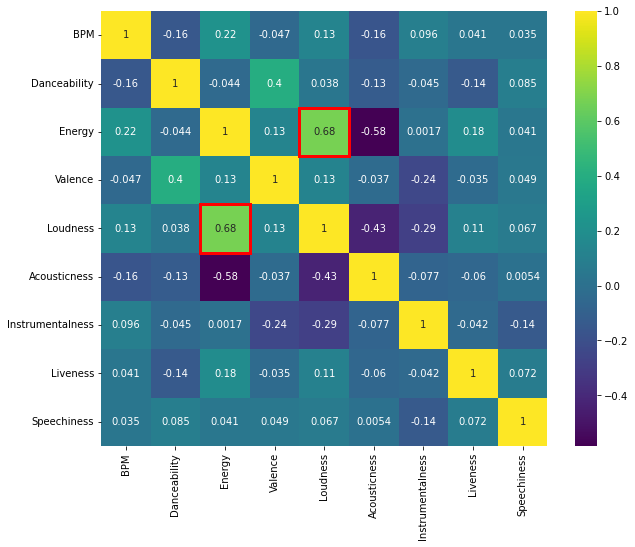

In [51]:
corr = final_dataset.corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(corr, cmap='viridis', annot=True)
ax.add_patch(Rectangle((2, 4), 1, 1, fill=False, edgecolor='red', lw=3))
ax.add_patch(Rectangle((4, 2), 1, 1, fill=False, edgecolor='red', lw=3));

<Figure size 720x720 with 0 Axes>

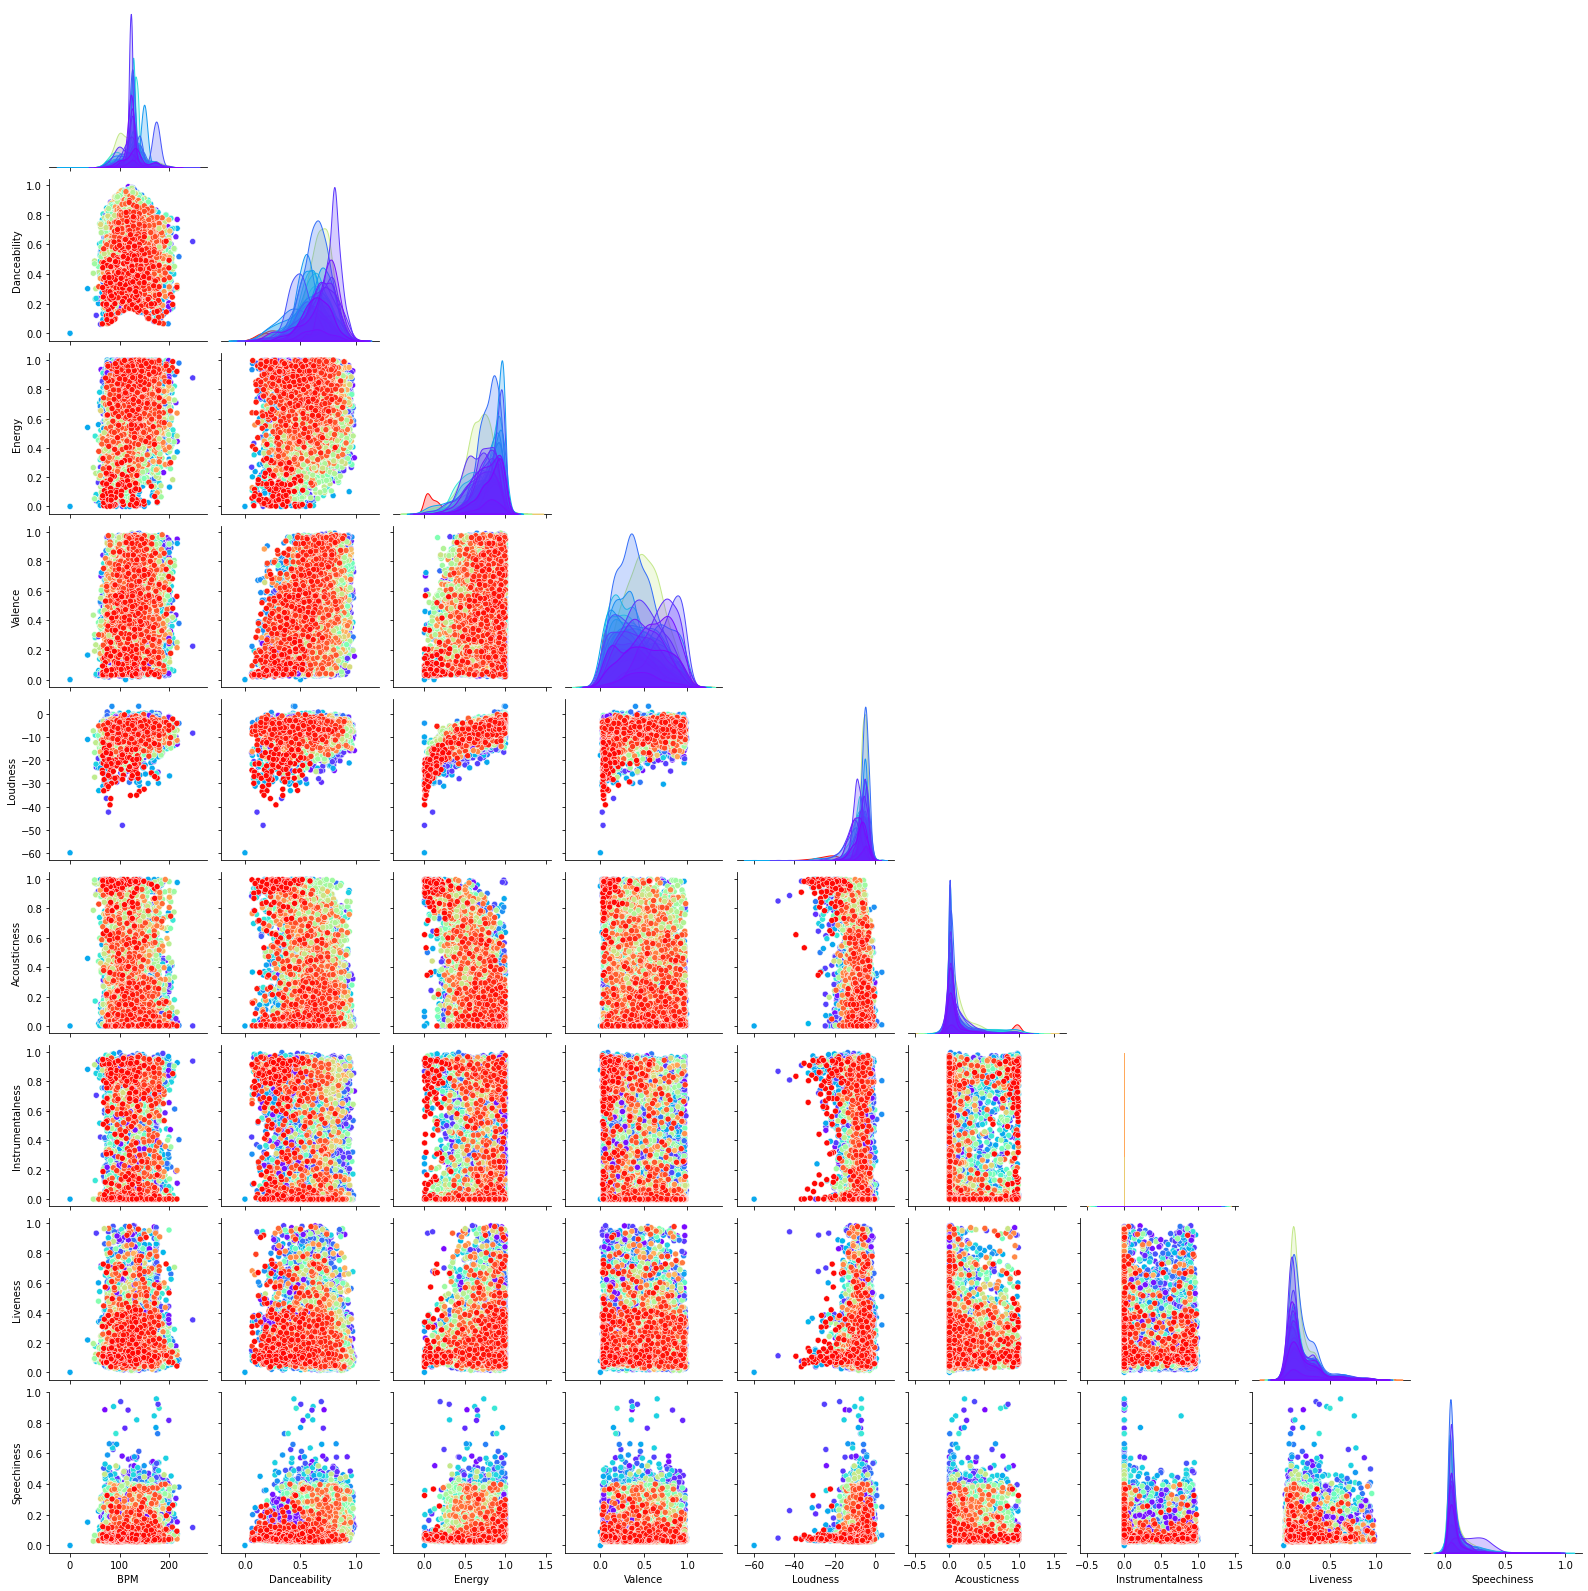

In [52]:
plt.figure(figsize=(10,10))
ax = sns.pairplot(final_dataset, hue='Sub-Genre', palette='rainbow', corner=True)
ax._legend.remove();

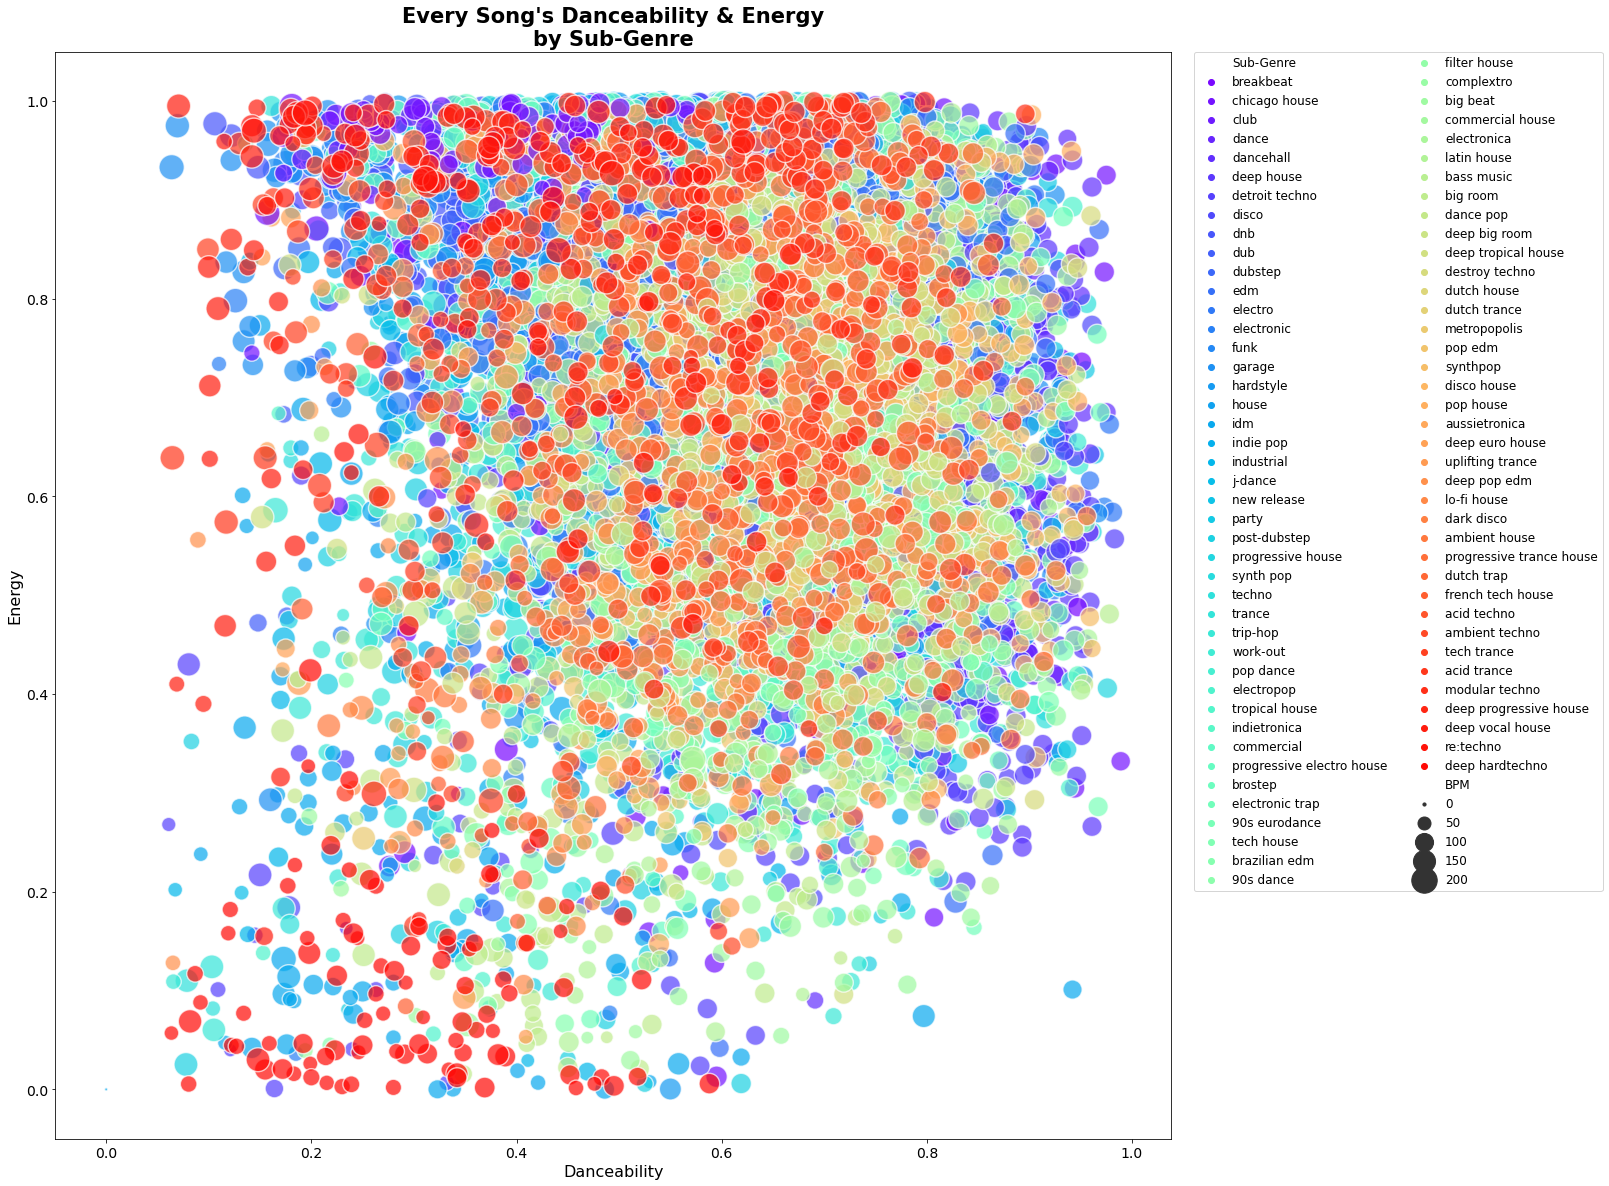

In [53]:
plt.figure(figsize=(20,20))

ax = sns.scatterplot(data=final_dataset, x='Danceability', y='Energy', 
                     hue='Sub-Genre', palette='rainbow',
                     size='BPM', sizes=(10,800), 
                     alpha=0.7)

ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., fontsize=12, ncol=2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Danceability', fontsize=16)
plt.ylabel('Energy', fontsize=16)
plt.title("Every Song's Danceability & Energy\nby Sub-Genre", fontsize=21, fontweight='bold');

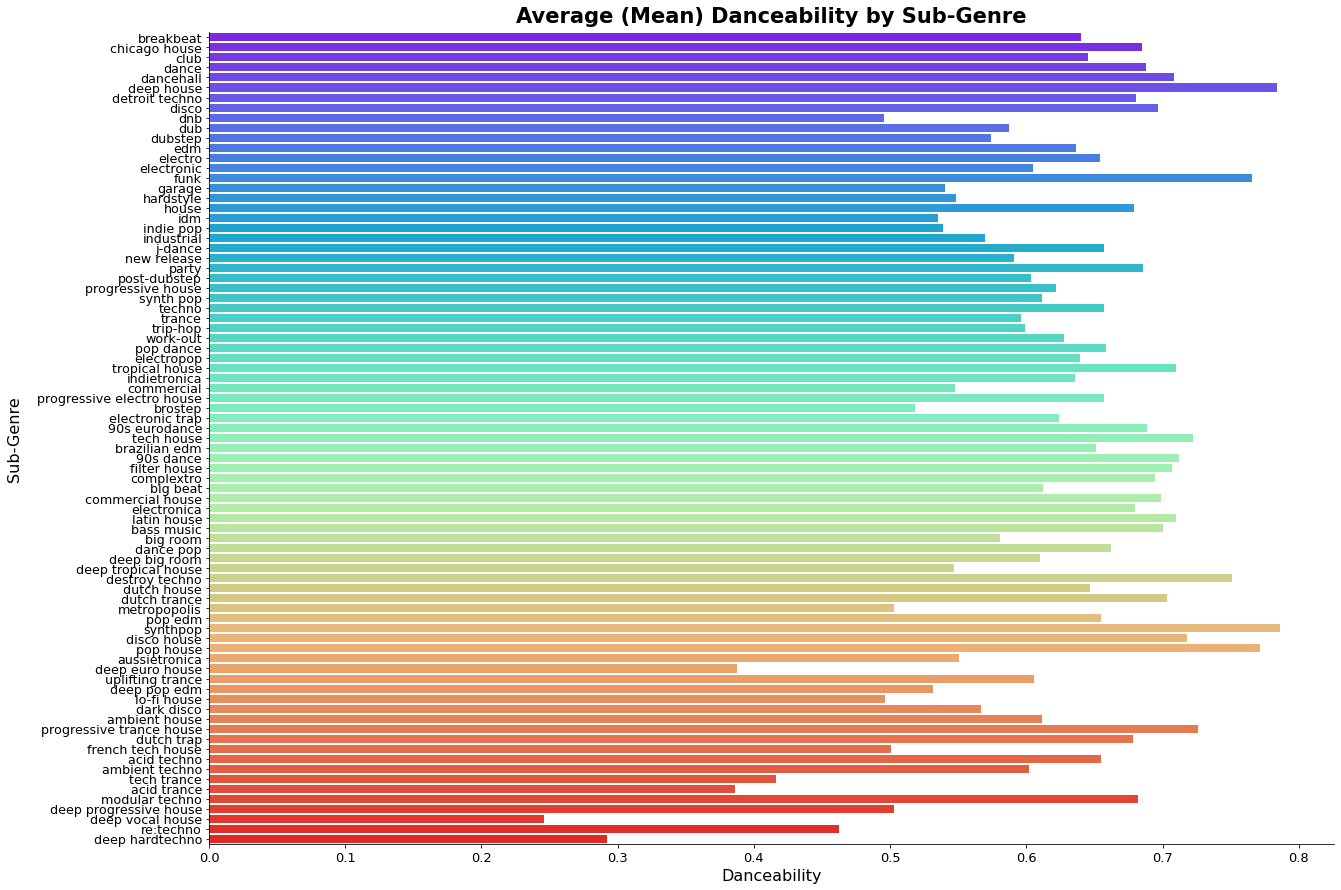

In [54]:
sns.catplot(x='Danceability', y='Sub-Genre', data=final_dataset, kind='bar',
            palette='rainbow', height=12, aspect=1.5, ci=None)
plt.xticks(fontsize=13)
plt.yticks(fontsize=12.7)
plt.xlabel('Danceability', fontsize=16)
plt.ylabel('Sub-Genre', fontsize=16, labelpad=15)
plt.title('Average (Mean) Danceability by Sub-Genre', fontsize=21,
          pad=10, fontweight='bold');

## Modeling
***

In [55]:
final_dataset[final_dataset['Sub-Genre'] == 'house'].head(20)

,Song_Title,Artists,Sub-Genre,BPM,Danceability,Energy,Valence,Loudness,Acousticness,Instrumentalness,Liveness,Speechiness,ID
1570,Let It Go (feat. Rudy) - Axwell Remix,Dirty South,house,127.000,0.798,0.744,0.3770,-7.765,0.049900,0.846000,0.2270,0.0889,4K1YwaDKANVH39xKso9oJp
1571,You Make Me - Avicii By Avicii,Avicii,house,125.024,0.648,0.936,0.7190,-4.990,0.043500,0.004560,0.2050,0.0819,7L9B87n4Hl0mBw2k1TBriW
1572,Where Have You Been - Hardwell Club Mix,Rihanna,house,128.020,0.758,0.917,0.2450,-5.196,0.003530,0.000474,0.3390,0.3360,0ildeK8p6UUkHGK94EW1m0
1573,Feed The Dada - Radio Edit,Dada Life,house,128.037,0.715,0.902,0.4410,-3.664,0.005430,0.000000,0.0972,0.1850,4osxePfXPhLLm1wlKs79Nw
1574,Pair of Dice (Radio Edit),Tiësto,house,128.022,0.493,0.918,0.2090,-4.370,0.000136,0.909000,0.8870,0.0583,1VWSVt3Q0nGbq2EHe2zJYJ
1575,Die Young,Kesha,house,128.001,0.711,0.700,0.8010,-4.805,0.004980,0.000125,0.2150,0.0460,6mnjcTmK8TewHfyOp3fC9C
1576,Hello,Martin Solveig,house,127.989,0.660,0.969,0.4800,-3.630,0.011000,0.002250,0.1160,0.0346,54fyVsVauzPwruLvGnBe3i
1577,Rewarded - SoundFactory Airwave Mix,Louis Sebastian,house,127.010,0.681,0.892,0.2420,-7.108,0.001930,0.138000,0.0856,0.0352,2Osx36dUt8s2zhWCYTkoo7
1578,Somebody That I Used To Know - Tiësto Remix,Gotye,house,129.000,0.632,0.637,0.4080,-6.138,0.000224,0.018500,0.0378,0.0408,4MVj6sUr4CxpdlklYrvtxU
1579,Call Me A Spaceman - Extended Mix,Hardwell,house,127.950,0.491,0.711,0.2240,-3.671,0.000400,0.003380,0.1470,0.0867,71lPvDJnM16yzqz917z0nt


In [56]:
genre_OHE = pd.get_dummies(final_dataset['Sub-Genre'])

In [57]:
scaled_features = MinMaxScaler().fit_transform([
  final_dataset['Acousticness'].values,
  final_dataset['Danceability'].values,
  final_dataset['Energy'].values,
  final_dataset['Instrumentalness'].values,
  final_dataset['Liveness'].values,
  final_dataset['Loudness'].values,
  final_dataset['Speechiness'].values,
  final_dataset['BPM'].values,
  final_dataset['Valence'].values])

model_df = pd.DataFrame()

model_df[['Acousticness_scal','Danceability_scal','Energy_scal',
               'Instrumentalness_scal','Liveness_scal','Loudness_scal',
               'Speechiness_scal','Tempo_scal','Valence_scal']] = scaled_features.T

model_df = model_df.join(genre_OHE)

model_df

,Acousticness_scal,Danceability_scal,Energy_scal,Instrumentalness_scal,Liveness_scal,Loudness_scal,Speechiness_scal,Tempo_scal,Valence_scal,90s dance,...,synth pop,synthpop,tech house,tech trance,techno,trance,trip-hop,tropical house,uplifting trance,work-out
0,0.047708,0.050033,0.050455,0.047151,0.048132,0.0,0.048139,1.0,0.048916,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.069686,0.068874,0.067836,0.065381,0.066173,0.0,0.065583,1.0,0.067733,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.057811,0.063203,0.063261,0.057792,0.058344,0.0,0.058053,1.0,0.064146,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.069060,0.075276,0.076045,0.076352,0.069940,0.0,0.069449,1.0,0.072220,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.062037,0.066302,0.068482,0.067275,0.064792,0.0,0.062346,1.0,0.064771,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18271,0.210101,0.207985,0.207092,0.206977,0.207302,0.0,0.207369,1.0,0.207175,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18272,0.109584,0.104857,0.103770,0.107862,0.103525,0.0,0.103229,1.0,0.103228,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18273,0.186804,0.182096,0.179885,0.186543,0.179556,0.0,0.179153,1.0,0.179564,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18274,0.196664,0.188420,0.188898,0.195140,0.187093,0.0,0.186920,1.0,0.186965,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Distance-Based Model

In [58]:
def distance_recommend(song_id, dataset_name, sp, n_recs=10):

    new_dataset = dataset_name.copy()

    new_dataset['BPM_scal'] = MinMaxScaler().fit_transform(dataset_name[['BPM']])

    new_dataset['all_features'] = new_dataset[['Danceability', 'Energy', 'Valence',
                                               'Loudness', 'Acousticness', 'Liveness',
                                               'Instrumentalness', 'Speechiness',
                                               'BPM_scal']].values.tolist()

    track_features = sp.track_audio_features(song_id)
    track_moodvec = np.array([track_features.acousticness, track_features.danceability,
                              track_features.energy, track_features.instrumentalness,
                              track_features.liveness, track_features.loudness,
                              track_features.speechiness, track_features.tempo,
                              track_features.valence])
    
    new_dataset['distances'] = new_dataset['all_features'].apply(lambda x: norm(track_moodvec-np.array(x)))

    rec_df_sorted = new_dataset.sort_values(by='distances', ascending=True)

    rec_df_sorted = rec_df_sorted[rec_df_sorted['ID'] != song_id]

    return rec_df_sorted.iloc[:n_recs]

Sander van Doorn - Koko, Index # 1582

In [59]:
distance_recommend('63FBHusPgw9X6tz66prs5N', final_dataset, sp)

,Song_Title,Artists,Sub-Genre,BPM,Danceability,Energy,Valence,Loudness,Acousticness,Instrumentalness,Liveness,Speechiness,ID,BPM_scal,all_features,distances
8154,My Comet,Onra,post-dubstep,174.509,0.443,0.733,0.652,-6.843,0.217000,0.000728,0.6170,0.956,45IiVcbBkiHUwK8GQFVlCe,0.703847,"[0.443, 0.733, 0.652, -6.843, 0.217, 0.617, 0....",127.632826
7720,My Life ft. Detin8,Roger Molls,trip-hop,180.063,0.463,0.866,0.192,-6.730,0.737000,0.000000,0.5020,0.895,79XADGXmqoq20IzKzFEfQF,0.726248,"[0.463, 0.866, 0.192, -6.73, 0.737, 0.502, 0.0...",127.680201
6426,Willing & Able,Disclosure,dance,199.727,0.525,0.643,0.945,-6.874,0.247000,0.000000,0.1060,0.816,4NSAqKiT1jtmoz9jMzLGw7,0.805559,"[0.525, 0.643, 0.945, -6.874, 0.247, 0.106, 0....",127.737470
7606,Public Service Announcement (Interlude),JAY-Z,party,178.213,0.422,0.973,0.567,-0.506,0.298000,0.000046,0.2100,0.541,3sFLrOAYhSXE6UPoovRS9a,0.718786,"[0.422, 0.973, 0.567, -0.506, 0.298, 0.21, 4.6...",127.788510
10203,Spin Doc,Sub Zero,dnb,174.977,0.545,0.979,0.420,-1.051,0.000101,0.839000,0.2590,0.536,4OyrEhUHEiKqGOYaDx30Gh,0.705735,"[0.545, 0.979, 0.42, -1.051, 0.000101, 0.259, ...",127.807573
4459,Tun Up,Various Artists,dancehall,110.917,0.708,0.500,0.538,-7.221,0.172000,0.000000,0.0988,0.765,4MTdlDkk7CE9xLU0p0Q2xc,0.447361,"[0.708, 0.5, 0.538, -7.221, 0.172, 0.0988, 0.0...",127.809490
3553,Kings Of The Underground - Radio Edit,Zatox,hardstyle,75.781,0.340,0.994,0.321,-4.191,0.056600,0.000004,0.0861,0.590,6UgE4xFyY9IOczVcvUijhI,0.305647,"[0.34, 0.994, 0.321, -4.191, 0.0566, 0.0861, 4...",127.825086
4817,Flight,Various Artists,electronic,87.383,0.434,0.755,0.217,-5.735,0.041500,0.000026,0.1060,0.659,66WcaWVGRFmpx0euxmw9yM,0.352442,"[0.434, 0.755, 0.217, -5.735, 0.0415, 0.106, 2...",127.829143
7703,Guns Blazing (Drums Of Death Pt. 1),UNKLE,trip-hop,92.694,0.391,0.892,0.177,-6.802,0.136000,0.000023,0.3840,0.730,3yY7mFehAwnRoNOAWwOWpZ,0.373863,"[0.391, 0.892, 0.177, -6.802, 0.136, 0.384, 2....",127.838598
10273,Can't Stop Me - Club Mix,Afrojack,house,130.037,0.537,0.872,0.233,-4.209,0.064900,0.000201,0.0896,0.578,1GPkSA6O4IrNG960dTSQ29,0.524478,"[0.537, 0.872, 0.233, -4.209, 0.0649, 0.0896, ...",127.838808


Martin Solveig - Hello, Index # 1576

In [60]:
distance_recommend('54fyVsVauzPwruLvGnBe3i', final_dataset, sp)

,Song_Title,Artists,Sub-Genre,BPM,Danceability,Energy,Valence,Loudness,Acousticness,Instrumentalness,Liveness,Speechiness,ID,BPM_scal,all_features,distances
8154,My Comet,Onra,post-dubstep,174.509,0.443,0.733,0.652,-6.843,0.217000,0.000728,0.6170,0.956,45IiVcbBkiHUwK8GQFVlCe,0.703847,"[0.443, 0.733, 0.652, -6.843, 0.217, 0.617, 0....",127.289557
7720,My Life ft. Detin8,Roger Molls,trip-hop,180.063,0.463,0.866,0.192,-6.730,0.737000,0.000000,0.5020,0.895,79XADGXmqoq20IzKzFEfQF,0.726248,"[0.463, 0.866, 0.192, -6.73, 0.737, 0.502, 0.0...",127.344334
6426,Willing & Able,Disclosure,dance,199.727,0.525,0.643,0.945,-6.874,0.247000,0.000000,0.1060,0.816,4NSAqKiT1jtmoz9jMzLGw7,0.805559,"[0.525, 0.643, 0.945, -6.874, 0.247, 0.106, 0....",127.415077
4459,Tun Up,Various Artists,dancehall,110.917,0.708,0.500,0.538,-7.221,0.172000,0.000000,0.0988,0.765,4MTdlDkk7CE9xLU0p0Q2xc,0.447361,"[0.708, 0.5, 0.538, -7.221, 0.172, 0.0988, 0.0...",127.486188
3982,Nano,Robot Koch,post-dubstep,170.096,0.568,0.658,0.645,-8.185,0.089800,0.767000,0.7660,0.845,4Shi5pX8qr7qFyKGV9ekCE,0.686048,"[0.568, 0.658, 0.645, -8.185, 0.0898, 0.766, 0...",127.487048
7703,Guns Blazing (Drums Of Death Pt. 1),UNKLE,trip-hop,92.694,0.391,0.892,0.177,-6.802,0.136000,0.000023,0.3840,0.730,3yY7mFehAwnRoNOAWwOWpZ,0.373863,"[0.391, 0.892, 0.177, -6.802, 0.136, 0.384, 2....",127.507260
7606,Public Service Announcement (Interlude),JAY-Z,party,178.213,0.422,0.973,0.567,-0.506,0.298000,0.000046,0.2100,0.541,3sFLrOAYhSXE6UPoovRS9a,0.718786,"[0.422, 0.973, 0.567, -0.506, 0.298, 0.21, 4.6...",127.508888
4817,Flight,Various Artists,electronic,87.383,0.434,0.755,0.217,-5.735,0.041500,0.000026,0.1060,0.659,66WcaWVGRFmpx0euxmw9yM,0.352442,"[0.434, 0.755, 0.217, -5.735, 0.0415, 0.106, 2...",127.516976
5841,Fishsh,Dead Fader,electronic,177.075,0.357,0.846,0.200,-7.205,0.004590,0.000086,0.0738,0.729,07Tb6OK5WsFBQSNvXU23lj,0.714196,"[0.357, 0.846, 0.2, -7.205, 0.00459, 0.0738, 8...",127.520917
10203,Spin Doc,Sub Zero,dnb,174.977,0.545,0.979,0.420,-1.051,0.000101,0.839000,0.2590,0.536,4OyrEhUHEiKqGOYaDx30Gh,0.705735,"[0.545, 0.979, 0.42, -1.051, 0.000101, 0.259, ...",127.522157
